# <center>  *Training different CNN model achitecture using genetic algorithms for image processessing* </center>

---

### Abstract
Train different CNN model achitectures using the genetic algorithm and then ensambling the best models from ech generation to make a super model, for image classifaction on the CIFAR-10 dataset.

### Introduction
This will be the introduction for my coursework.

### Learning objective
This is where my abstract will be

### Content
This is where my abstract will be

---

## Libraries


In [51]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

import random


---

## Dataset

The dataset used is the CIFAR10 for training.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. <br>
There are 50000 training images and 10000 test images.


In [52]:
#CIFAR10 dataset

# Load and normalise CIFAR10 dataset from Source [1]
# Define a transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Set the batch size for loading data
batch_size = 4

# Download and load the training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Download and load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define the classes in the dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### End of source [1]

# source [1] : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html 

Files already downloaded and verified
Files already downloaded and verified


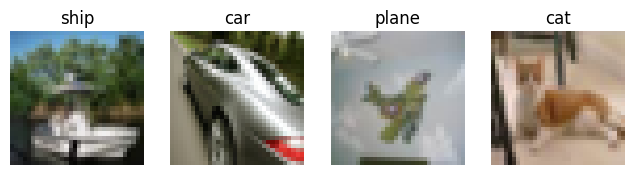

In [53]:
#function that shows images with their labels
def show_images_labels(images, labels):
    plt.figure(figsize=(10, 4))
    for i in range(4):
        plt.subplot(2, 5, i + 1)
        img = images[i] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(f"{classes[labels[i]]}")
        plt.axis('off')
    plt.show()

# get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)

show_images_labels(images, labels)

---

## Base Model Implementation

For our base neural network model we will be defining a CNN model ....


In [54]:
# Define the CNN model from Source [2] modified so it can be used for CIFAR10 dataset
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)
### End of source [2]

In [55]:
class LeNet5(nn.Module):
    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 6*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5*in_channels, 120*in_channels),
            nn.Tanh(),
            nn.Linear(120*in_channels, 84*in_channels),
            nn.Tanh(),
            nn.Linear(84*in_channels, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

# Modify the crossover function to handle LeNet5
def crossover(parent1, parent2):
    child1 = LeNet5(num_classes=10)
    child2 = LeNet5(num_classes=10)

    # Perform crossover on the convolutional layers
    child1.features[0].weight.data = torch.cat((parent1.features[0].weight.data[:3], parent2.features[0].weight.data[3:]), dim=0)
    child2.features[0].weight.data = torch.cat((parent2.features[0].weight.data[:3], parent1.features[0].weight.data[3:]), dim=0)

    # Perform crossover on the fully connected layers
    child1.classifier[0].weight.data = torch.cat((parent1.classifier[0].weight.data[:60], parent2.classifier[0].weight.data[60:]), dim=0)
    child2.classifier[0].weight.data = torch.cat((parent2.classifier[0].weight.data[:60], parent1.classifier[0].weight.data[60:]), dim=0)

    return child1, child2

# Modify the mutation function to handle LeNet5
def mutate(model, mutation_rate):
    for param in model.parameters():
        if torch.rand(1).item() < mutation_rate:
            param.data += torch.randn(param.data.size()) * 0.1  # add random noise to the parameter
    return model

In [56]:
def train_nn_lenet(model, trainloader, criterion, optimizer, epochs=2, use_gpu=True):
    """
    Train a PyTorch neural network model efficiently.
    
    Args:
        model: PyTorch model to train (updated in-place).
        trainloader: DataLoader containing training data.
        criterion: Loss function.
        optimizer: Optimizer (Adam, SGD, etc.).
        epochs (int, optional): Number of training epochs. Default is 2.
        use_gpu (bool, optional): If True, enables GPU acceleration.

    Returns:
        train_losses: List of training losses over time.
        training_time: Total time taken to train the model.
    """
    # Use GPU if available and selected
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU

    model.train()  # Set model to training mode
    train_losses = []

    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(trainloader, start=1):
            # Move inputs and labels to the correct device (CPU/GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            ### FORWARD AND BACK PROP
            logits, probas = model(inputs)
            loss = F.cross_entropy(logits, labels)
            optimizer.zero_grad()
            
            loss.backward()
            
            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            running_loss += loss.item()

            # Log loss statistics every 2000 mini-batches
            if i % 2000 == 0:
                avg_loss = running_loss / 2000
                print(f'Epoch: {epoch}, Batch: {i}, Avg. Loss: {avg_loss:.4f}')
                train_losses.append(avg_loss)
                running_loss = 0.0  # Reset running loss
    end_time = time.time()

    training_time = end_time - start_time
    print('Finished Training')
    return train_losses, training_time

In [57]:
def test_nn_lenet(model, data_loader, use_gpu=True):
    """
    Efficiently tests the LeNet model on all images in the data loader and returns overall accuracy.

    Args:
        data_loader: PyTorch DataLoader for test data.
        model: Trained PyTorch model.
        use_gpu (bool, optional): If True, uses GPU if available. Default is True.

    Returns:
        overall_accuracy (float): Accuracy of the model on the data loader.
    """
    # Select device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    correct = 0
    total = 0

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for features, targets in data_loader:
            features, targets = features.to(device), targets.to(device)  # Move data to GPU/CPU
            logits, probas = model(features)
            _, predicted_labels = torch.max(probas, 1)  # Get predicted class

            # Update total and correct predictions
            total += targets.size(0)
            correct += (predicted_labels == targets).sum().item()

    # Compute overall accuracy
    overall_accuracy = 100 * correct / total

    print(f"Overall Model Accuracy: {overall_accuracy:.2f}%")
    return overall_accuracy


In [58]:
def train_nn(model, trainloader, criterion, optimizer, epochs=2, use_gpu=True):
    """
    Train a PyTorch neural network model efficiently.
    
    Args:
        model: PyTorch model to train (updated in-place).
        trainloader: DataLoader containing training data.
        criterion: Loss function.
        optimizer: Optimizer (Adam, SGD, etc.).
        epochs (int, optional): Number of training epochs. Default is 2.
        use_gpu (bool, optional): If True, enables GPU acceleration.

    Returns:
        train_losses: List of training losses over time.
        training_time: Total time taken to train the model.
    """
    # Use GPU if available and selected
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU

    model.train()  # Set model to training mode
    train_losses = []

    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(trainloader, start=1):
            # Move inputs and labels to the correct device (CPU/GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()

            # Log loss statistics every 2000 mini-batches
            if i % 2000 == 0:
                avg_loss = running_loss / 2000
                train_losses.append(avg_loss)
                running_loss = 0.0  # Reset running loss
    end_time = time.time()

    training_time = end_time - start_time
    print('Finished Training')
    return train_losses, training_time

In [59]:
def test_nn(testloader, model, use_gpu=True):
    """
    Efficiently tests the model on all images in the test set and returns overall accuracy.

    Args:
        testloader: PyTorch DataLoader for test data.
        model: Trained PyTorch model.
        use_gpu (bool, optional): If True, uses GPU if available. Default is True.

    Returns:
        overall_accuracy (float): Accuracy of the model on the test set.
    """
    # Select device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    correct = 0
    total = 0

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)  # Get predicted class

            # Update total and correct predictions
            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    # Compute overall accuracy
    overall_accuracy = 100 * correct / total

    print(f"Overall Model Accuracy: {overall_accuracy:.2f}%")
    return overall_accuracy


In [60]:
def test_4_random_images(testloader, model, classes, use_gpu=True):
    """
    Visually tests the model on 4 random images from the test set and computes approximate accuracy.

    Args:
        testloader: PyTorch DataLoader for test data.
        model: Trained PyTorch model.
        classes: List of class labels.
        use_gpu (bool, optional): Whether to use GPU if available.

    Returns:
        accuracy (float): Model accuracy on the 4 randomly selected images.
    """
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU
    model.eval()  # Set model to evaluation mode

    # Get a random batch from the testloader
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # Select 4 random indices from the batch
    indices = random.sample(range(len(images)), 4)
    selected_images = images[indices]
    selected_labels = labels[indices]

    # Move data to GPU if available
    selected_images, selected_labels = selected_images.to(device), selected_labels.to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(selected_images)
        _, predicted = torch.max(outputs, 1)

    # Compute accuracy
    correct = (predicted == selected_labels).sum().item()
    accuracy = correct / len(selected_labels) * 100

    # Display images with labels and predictions
    show_images_labels(selected_images.cpu(), selected_labels.cpu())
    print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))
    print(f'Accuracy on these 4 images: {accuracy:.2f}%')

    return accuracy

In [61]:
def test_nn_per_class(testloader, model, classes, use_gpu=True):
    """
    Efficiently tests the model on all images in the test set and returns per-class accuracy.

    Args:
        testloader: PyTorch DataLoader for test data.
        model: Trained PyTorch model.
        classes: List of class labels.
        use_gpu (bool, optional): If True, uses GPU if available. Default is True.

    Returns:
        class_accuracies (dict): Dictionary containing accuracy for each class.
    """
    # Select device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # Prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)  # Get predicted class

            # Update per-class statistics
            for label, prediction in zip(labels, predictions):
                total_pred[classes[label.item()]] += 1  # Count total instances of each class
                if label == prediction:
                    correct_pred[classes[label.item()]] += 1  # Count correct predictions

    # Compute per-class accuracy
    class_accuracies = {
        classname: (100 * correct_pred[classname] / total_pred[classname]) if total_pred[classname] > 0 else 0.0
        for classname in classes
    }

    print("Finished per-class testing.")
    return class_accuracies


---

## Genetic Algorithm Implementation

<b> What is a Genetic algorithm?<b>

In [62]:
def compute_fitness(criterion, model, optimizer, trainloader, testloader,epochs):
    # Train the model
    train_nn(model, trainloader, criterion, optimizer, epochs)

    # test the model.
    test_accuracy = test_nn(testloader, model)
    return test_accuracy

In [63]:
# write a function to initialise the population
def initialise_population(population_size):
    population = []
    for _ in range(population_size):
        model = CNN()
        population.append(model)
    return population

In [64]:
# write the function to perform the crossover operation
def crossover(parent1, parent2):
    child1 = CNN()
    child2 = CNN()

    child1.conv1.weight.data = torch.cat((parent1.conv1.weight.data[:16], parent2.conv1.weight.data[16:]), dim=0)
    child2.conv1.weight.data = torch.cat((parent2.conv1.weight.data[:16], parent1.conv1.weight.data[16:]), dim=0)
    return child1, child2

In [65]:
# write the function to perform the mutation operation
def mutate(model, mutation_rate):
    for param in model.parameters():
        if torch.rand(1).item() < mutation_rate:
            param.data += torch.randn(param.data.size()) * 0.1 # add random noise to the parameter
    return model

In [66]:
def run_genetic_algorithm(criterion, population_size, generations, trainloader, testloader, epochs, mutation_rate):
    """
    Runs a Genetic Algorithm (GA) to optimize a neural network model.

    Args:
        population_size (int): Number of models in the population.
        generations (int): Number of generations to evolve.
        trainloader: PyTorch DataLoader for training data.
        testloader: PyTorch DataLoader for test data.
        epochs (int): Number of epochs for fitness evaluation.
        mutation_rate (float): Probability of mutation.

    Returns:
        results (dict): Dictionary containing:
            - 'best_model': Best model from the final generation.
            - 'generation_times': List of time taken for each generation.
            - 'best_accuracies': List of best accuracies from each generation.
    """
    

    # Initialize the population
    population = initialise_population(population_size)

    # Tracking metrics
    generation_times = []
    best_accuracies = []

    # Start Genetic Algorithm process
    for generation in range(generations):
        print(f"\nGeneration {generation + 1}")

        best_accuracy = 0
        best_model = None
        fitness_scores = np.zeros(population_size)  # Preallocate array for fitness scores

        # Start timer for the generation
        start_time = time.time()

        # Evaluate fitness for each model
        for i, model in enumerate(population):
            optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Define optimizer
            fitness = compute_fitness(criterion, model, optimizer, trainloader, testloader,epochs)
            fitness_scores[i] = fitness

            if fitness > best_accuracy:
                best_accuracy = fitness
                best_model = model

        # End timer for the generation
        end_time = time.time()
        generation_time = end_time - start_time

        # Store time and best accuracy for visualization
        generation_times.append(generation_time)
        best_accuracies.append(best_accuracy)

        print(f'Best accuracy in generation {generation + 1} = {best_accuracy:.4f}')
        print(f'Time taken for generation {generation + 1}: {generation_time:.2f} seconds')

        # **Parent Selection**
        top_indices = np.argsort(fitness_scores)[-population_size // 2:]  # Get top 50%
        selected_parents = [population[i] for i in top_indices]

        next_generation = []

        # **Crossover & Mutation**
        for i in range(0, len(selected_parents), 2):
            parent1 = selected_parents[i]
            parent2 = selected_parents[i + 1]

            # Perform crossover
            child1, child2 = crossover(parent1, parent2)

            # Apply mutation
            mutate(child1, mutation_rate)
            mutate(child2, mutation_rate)

            next_generation.append(child1)
            next_generation.append(child2)

        # Ensure the population size remains constant
        population = next_generation[:population_size]

    # **Return the best model and collected data for visualization**
    results = {
        "best_model": best_model,
        "generation_times": generation_times,
        "best_accuracies": best_accuracies
    }

    return results


---

## Evaluation Function

In [67]:
#This function will be used to evaluate the network.
def evaluate_model(model, trainloader, testloader, classes, epochs=5, use_gpu=True, show_graph=True, tain = True):
    """
    Trains and evaluates a PyTorch model while tracking losses and accuracies.

    Args:
        model: PyTorch model to train and evaluate.
        trainloader: DataLoader containing training data.
        testloader: DataLoader containing test data.
        classes: List of class labels.
        epochs (int, optional): Number of training epochs. Default is 10.
        use_gpu (bool, optional): If True, enables GPU acceleration. Default is True.
        show_graph (bool, optional): If True, displays accuracy/loss graphs. Default is True.

    Returns:
        results (dict): Dictionary containing:
            - 'train_losses': List of training losses.
            - 'train_accuracies': List of training accuracies.
            - 'test_accuracies': List of test accuracies.
            - 'test_class_accuracies': Dictionary of per-class accuracy.
            - 'final_test_accuracy': Final overall test accuracy.
            - 'total_time': Total time taken for training.
    """
    # Specify the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Move model to GPU if available
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize tracking variables
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    total_time = 0

    if tain:
        # Training and Evaluation Loop
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")

            # Train the model for one epoch
            train_loss, train_time = train_nn(model, trainloader, criterion, optimiser, epochs=1, use_gpu=use_gpu)
            total_time += train_time

            # Test the model after training
            test_accuracy = test_nn(testloader, model, use_gpu=use_gpu)

            # Store losses and accuracies
            train_losses.append(train_loss[-1])  # Store the last batch loss of the epoch
            train_accuracies.append(test_nn(trainloader, model, use_gpu=use_gpu))
            test_accuracies.append(test_accuracy)

            print(f'Epoch {epoch+1}: Train Loss: {train_loss[-1]:.4f}, Test Accuracy: {test_accuracy:.2f}%')
        
        # Final test accuracy after all epochs
        final_test_accuracy = test_accuracies[-1]
    else:
        final_test_accuracy = test_nn(testloader, model, use_gpu=use_gpu)


    # final test acuracy per class
    test_class_accuracies = test_nn_per_class(testloader, model, classes, use_gpu=use_gpu)

    if show_graph:
        if tain:
            # Plot training vs testing accuracy if enabled
            plt.figure(figsize=(12, 6))
            plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
            plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
            plt.title('Training vs Testing Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy (%)')
            plt.legend()
            plt.grid(True)
            plt.show()

            #plot the loss curve over time as the model trained
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss', color='blue')
            plt.xlabel('Batch (x2000)')
            plt.ylabel('Loss')
            plt.title('Training Loss Over Time')
            plt.legend()
            plt.legend()
            plt.grid(True)
            plt.show()       

        # Plot per-class accuracy if enabled
        plt.figure(figsize=(10, 5))
        plt.bar(test_class_accuracies.keys(), test_class_accuracies.values(), color='blue')
        plt.xlabel("Classes")
        plt.ylabel("Accuracy (%)")
        plt.title("Model Accuracy Per Class")
        plt.xticks(rotation=45)  # Rotate class names for readability
        plt.ylim(0, 100)  # Set y-axis range to 0-100%
        plt.show()

        # print per-class accuracy
        for classname, accuracy in test_class_accuracies():
            print(f'Accuracy for class {classname:5s}: {accuracy:.1f}%')

    # Return all results in a dictionary
    results = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies,
        "test_class_accuracies": test_class_accuracies,
        "final_test_accuracy": final_test_accuracy,
        "total_time": total_time
    }

    return results

---
## Comparitive Analysis and Results


### Base model results


In [ ]:
# Define model, optimizer, and loss function
base = CNN()
optimizer = optim.Adam(base.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_nn(base, trainloader, criterion, optimizer, epochs=2, use_gpu=True)
print("Base accuracy: ", test_nn(testloader, base, use_gpu=True))

# evaluate the base model
base_results = evaluate_model(base, trainloader, testloader, classes, epochs=5, use_gpu=True, show_graph=True)

In [ ]:
# Define model, optimizer, and loss function
LeNet5_base = LeNet5(num_classes=10)
optimizer = optim.Adam(LeNet5_base.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_nn_lenet(LeNet5_base, trainloader, criterion, optimizer, epochs=2, use_gpu=True)
print("Base accuracy: ", test_nn_lenet(LeNet5_base, testloader, use_gpu=True))

# evaluate the base model
# LeNet5_base_results = evaluate_model(LeNet5_base, trainloader, testloader, classes, epochs=5, use_gpu=True, show_graph=True)

Epoch: 0, Batch: 2000, Avg. Loss: 1.8923
Epoch: 0, Batch: 4000, Avg. Loss: 1.6340
Epoch: 0, Batch: 6000, Avg. Loss: 1.5270
Epoch: 0, Batch: 8000, Avg. Loss: 1.4762
Epoch: 0, Batch: 10000, Avg. Loss: 1.4367
Epoch: 0, Batch: 12000, Avg. Loss: 1.3894
Epoch: 1, Batch: 2000, Avg. Loss: 1.3183
Epoch: 1, Batch: 4000, Avg. Loss: 1.3230
Epoch: 1, Batch: 6000, Avg. Loss: 1.3334
Epoch: 1, Batch: 8000, Avg. Loss: 1.3256
Epoch: 1, Batch: 10000, Avg. Loss: 1.2845
Epoch: 1, Batch: 12000, Avg. Loss: 1.3001
Finished Training
Overall Model Accuracy: 52.63%
Base accuracy:  52.63

Epoch 1/5


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not tuple

### Genetic algorithm results

In [ ]:
# Set the number of generations
generations = 2

# Set the population size
population_size = generations * 2

# Set the mutation rate
mutation_rate = 0.1

# Set the number of epochs
epochs = 5

criterion = nn.NLLLoss()

# Run the Genetic Algorithm
ga_results = run_genetic_algorithm(criterion, population_size, generations,trainloader,testloader,epochs,mutation_rate)

# Access results
ga_best_model = ga_results["best_model"]
generation_times = ga_results["generation_times"]
best_accuracies = ga_results["best_accuracies"]

# Print summary
print(f"\nFinal Best Model Accuracy: {best_accuracies[-1]:.2f}%")
print(f"Time Taken Per Generation: {generation_times}")

# save the best model
torch.save(ga_best_model.state_dict(), 'best_model.pth')

In [ ]:
#plot a graph of the best accuracies
plt.plot(best_accuracies)
plt.xlabel('Generation')
plt.ylabel('Best Accuracy')
plt.title('Best Accuracy vs Generation')
plt.show()

#plot a graph of the generation times
plt.plot(generation_times)
plt.xlabel('Generation')
plt.ylabel('Time (s)')
plt.title('Generation Time')
plt.show()

# evaluate the genetic algotithm's best model
ga_best_model_results = evaluate_model(ga_best_model, trainloader, testloader, classes, epochs=5, use_gpu=True, show_graph=True, tain = False)

### Optimized Genetic algorithma results

---
## Conclusion



---
## Tutorial comparison


---
## References


source [1] : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html 
source [2] : https://www.geeksforgeeks.org/how-to-implement-genetic-algorithm-using-pytorch/ 